# SIDES Simulation

This directory contains models made with simulations generated using [SIDES](https://gitlab.lam.fr/mbethermin/sides-public-release/-/tree/main/PYSIDES).  

The catalog and maps generated in the Notebook (S0_Generate_Simulated_Herschel_Maps_and_Catlog)[./S0_Generate_Simulated_Herschel_Maps_and_Catlog] were stacked, and this Notebook is an analysis of the results.  

In [1]:
# Standard modules
import pdb
import sys
import os
import pickle
import numpy as np
import pandas as pd
from lmfit import Parameters, minimize, fit_report
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots
from simstacktoolbox import SimstackToolbox

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_4_5_6p0_X_4_foregnd_atonce_bootstrap_1-70"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "sides_simulation.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [18]:
simstack_catalog_object.catalog_dict['tables']['full_table'].tail()

,Unnamed: 0,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850,Trf,Ain
361480,361480,8.601702,0.416990,0.015490,1.572414e+09,False,13.236866,1.323687e+11,1.203157e-08,7.719299e-07,0.000003,0.000006,0.000027,0.000054,0.000064,39.307918,-33.932404
361481,361481,8.566001,0.239313,0.308510,2.291832e+09,False,19.834282,1.983428e+11,2.547088e-08,1.650851e-06,0.000006,0.000013,0.000053,0.000108,0.000140,39.689883,-33.670603
361482,361482,8.648121,0.974505,1.053851,4.165142e+09,False,14.366696,1.436670e+11,1.746845e-08,1.093338e-06,0.000004,0.000009,0.000035,0.000073,0.000098,40.874420,-33.904004
361483,361483,8.732985,0.035478,1.327398,3.519983e+09,False,15.789969,1.578997e+11,1.082463e-08,6.367038e-07,0.000003,0.000005,0.000021,0.000045,0.000058,29.076731,-33.086036
361484,361484,8.719206,0.866146,0.510229,1.293671e+09,False,38.969204,3.896920e+11,4.499536e-08,2.662770e-06,0.000011,0.000022,0.000091,0.000188,0.000239,41.175243,-33.491933


In [3]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [4]:
# Inspect object keys
simstack_object.results_dict['band_results_dict'].keys()

dict_keys(['mips_24', 'pacs_green', 'pacs_red', 'spire_psw', 'spire_pmw', 'spire_plw'])

In [5]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [6]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [7]:
# Call parse_results which translates the raw results into a results_dict for plotting/interpreting.
simstack_object.parse_results(catalog_object=simstack_catalog_object, estimate_mcmcs=False)

In [8]:
# Extract SEDs Dict
sed_results_dict = simstack_object.results_dict['sed_bootstrap_results_dict']

In [9]:
# Extract Bootstrap Dict
bootstrap_results_dict = simstack_object.results_dict['bootstrap_results_dict']

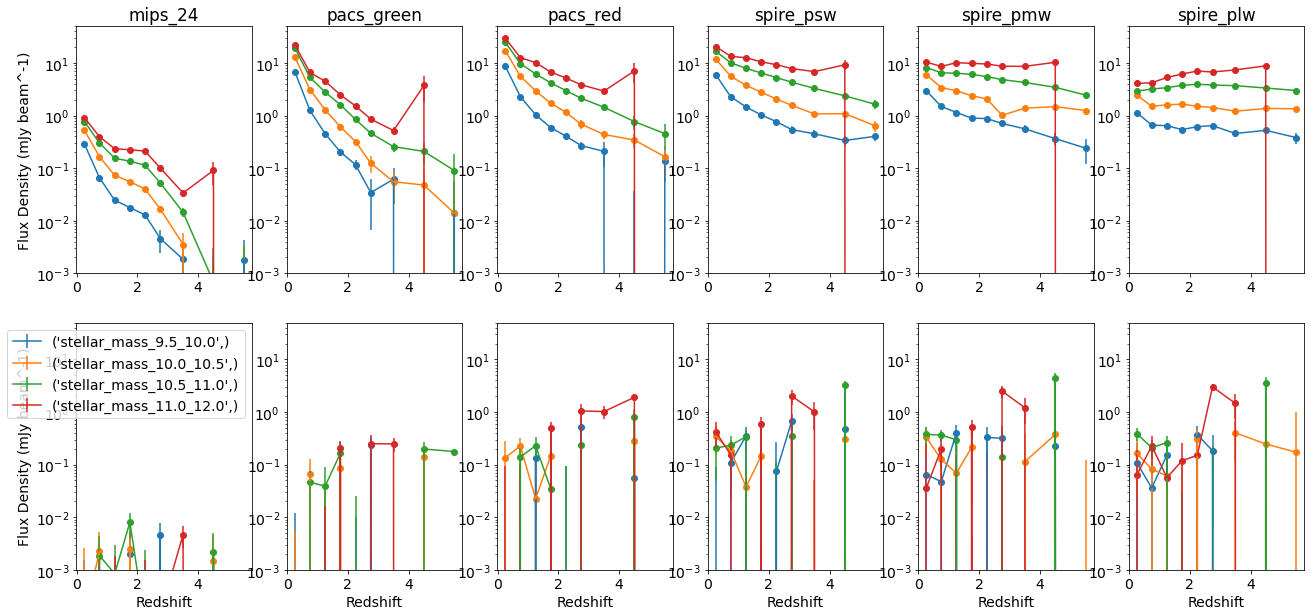

In [10]:
# Plot Stacked Flux Densities
simstack_object.plot_flux_densities()

In [19]:
color = ['b','y','g','r','m']
def plot_flux_density_histograms(self, iwv=0, ylog=True, ylim=[1e-3, 5e1], wv_cat = ["SMIPS24","S100","S160","SSPIRE250","SSPIRE350","SSPIRE500"]):
    ''' Compare histograms of the flux densities of the objects in each band, and their means, to the stacked flux densities returned by simstack.
    '''
    par_keys = self.config_dict['parameter_names']
    wv_keys = list(self.results_dict['band_results_dict'].keys())
    wlen = len(wv_keys)
    zlen = len(self.config_dict['parameter_names']['redshift'])
    mlen = 4
    plen = 2
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(wlen, zlen, width_ratios=width_ratios,
                       wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(34, 18))
    
    wlab = wv_keys[iwv]
    for ip, plab in enumerate(self.results_dict['band_results_dict'][wlab]['raw_fluxes_dict']['flux_df']):
        if not ip:
            flux_df = self.results_dict['band_results_dict'][wlab]['raw_fluxes_dict']['flux_df'][plab]
            error_df = self.results_dict['band_results_dict'][wlab]['raw_fluxes_dict']['error_df'][plab]
            for im, mlab in enumerate(flux_df):
                for iz, zmed in enumerate(flux_df[mlab].index):
                    zlab = self.config_dict['parameter_names']['redshift'][iz].replace('redshift_','z=').replace('_','-')

                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_xlim([-5.5,-1.5])
                    #ax.set_ylim([-5,-2])
                    ax.set_title(zlab)

                    m = [float(i) for i in mlab[0].split('_')[2:]]
                    z = [float(i) for i in par_keys['redshift'][iz].split('_')[1:]]
                    ind_bin = (simstack_catalog_object.catalog_dict['tables']['full_table']['redshift'] > z[0]) & \
                    (simstack_catalog_object.catalog_dict['tables']['full_table']['redshift'] < z[1]) & \
                    (simstack_catalog_object.catalog_dict['tables']['full_table']['Mstar'] >= 10**m[0]) & \
                    (simstack_catalog_object.catalog_dict['tables']['full_table']['Mstar'] < 10**m[1]) & \
                    (simstack_catalog_object.catalog_dict['tables']['full_table']['qflag'] == ip)

                    ngals = len(simstack_catalog_object.catalog_dict['tables']['full_table'][wv_cat[iwv]][ind_bin])
                    hy, hx = np.histogram(np.log10(simstack_catalog_object.catalog_dict['tables']['full_table'][wv_cat[iwv]][ind_bin]))
                    sim_y = np.mean(simstack_catalog_object.catalog_dict['tables']['full_table'][wv_cat[iwv]][ind_bin])
                    ax.step((hx[:-1]+hx[1:])/2,10^hy, c=color[im])

                    ax.vlines(np.log10(sim_y), min(hy), max(hy), color=color[im], ls='--', lw=2, label='sides={0:.1e}'.format(sim_y))
                    ax.vlines(np.log10(flux_df[mlab].values[iz]), min(hy), max(hy), color='k', ls=':', lw=3, label='simstack={0:.1e}'.format(flux_df[mlab].values[iz]))

                    ax.set_yscale('log')
                    
                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('Flux Density [Jy]')
                        
                    if iz:
                        ax.set_yticklabels([])
                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab[0].replace('stellar_mass_', 'log(M)=').replace('_', '-'))
                    ax.text(-5.3, float(np.max(10^hy))/1.5, "Ngals={0:0d}".format(ngals),fontsize=12)
                    ax.legend(loc='lower left')


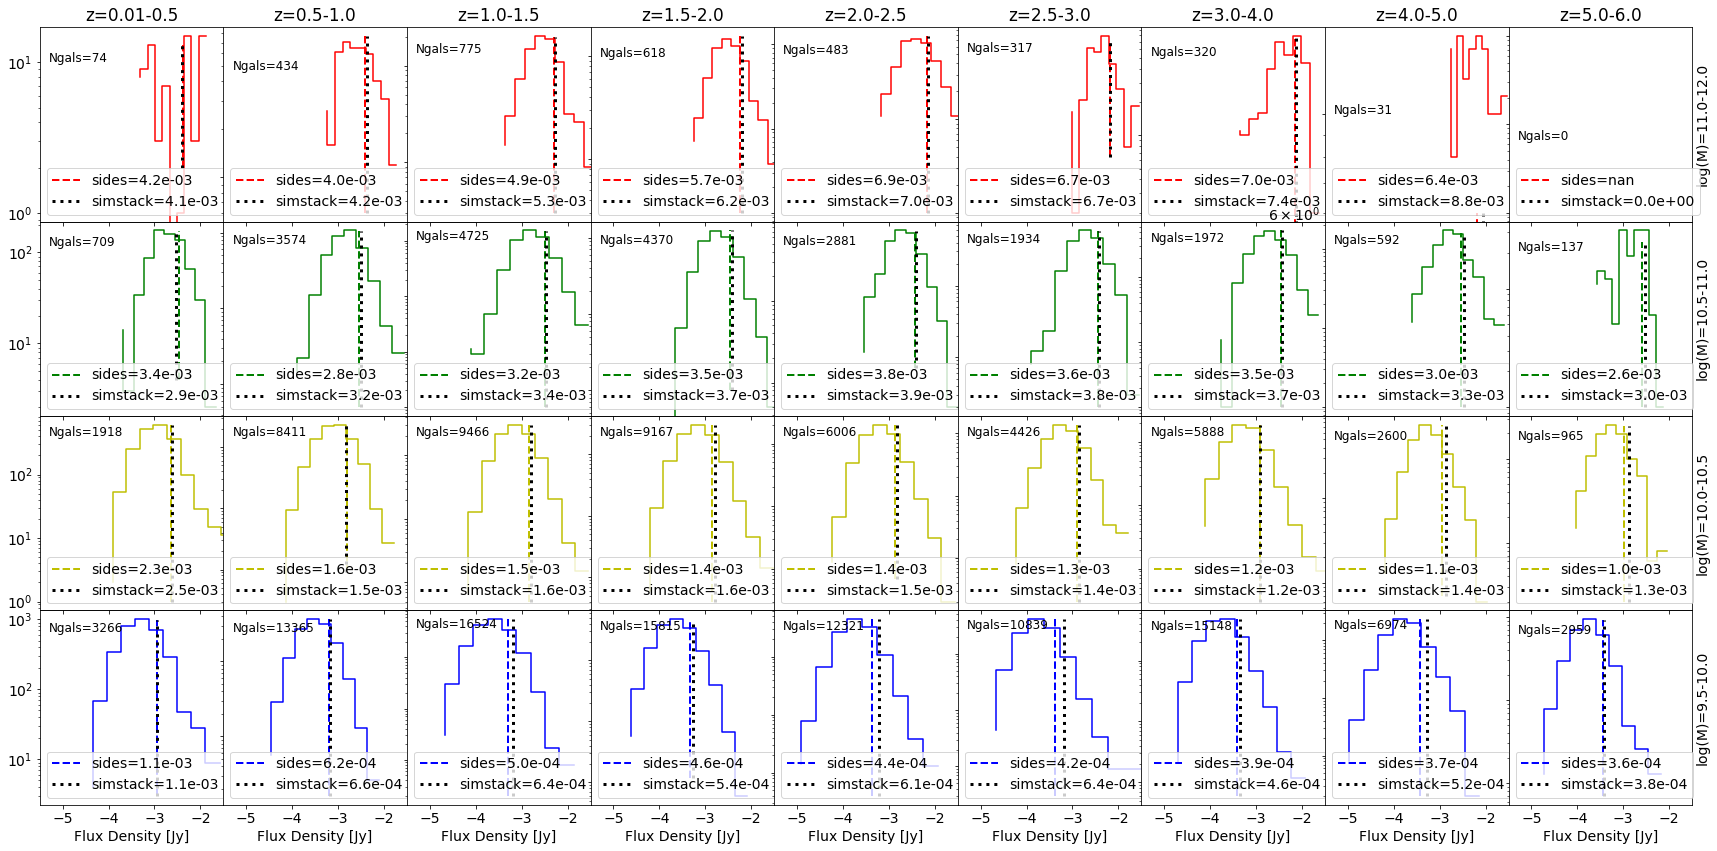

In [21]:
# Flux densities of input source catalog (histograms) and their mean (dashed lines) vs. Simstack flux densities (black dotted line) in single waveband
wv = 5  # For SSPIRE500
plot_flux_density_histograms(simstack_object, iwv=wv)